In [1]:
# %%capture
# # !pip install "unsloth==0.2.13" --force-reinstall
# !pip install datasets
# # Also get the latest nightly Unsloth!
# !pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [2]:
# Add this as a new cell at the very beginning (Cell 0):
import torch
import gc

# Clear GPU cache
gc.collect()
torch.cuda.empty_cache()

# Reset CUDA context
torch.cuda.synchronize()
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"Memory reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

GPU: NVIDIA A10
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB


In [3]:
%%capture
import os, re, gc
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth unsloth_zoo
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2
!pip install tensorboard tensorboardX

In [4]:
!pip list | grep "unsloth_zoo"

unsloth_zoo              2025.9.14


In [5]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
# load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    # load_in_4bit = load_in_4bit, #change this to load_in_8bit = True if 8bit config req
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

/home/ubuntu/DiskUsEast1/finetuning_evaluation/venv_aqi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.11: Fast Llama patching. Transformers: 4.55.4.
   \\   /|    NVIDIA A10. Num GPUs = 1. Max memory: 22.069 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu118. CUDA: 8.6. CUDA Toolkit: 11.8. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [6]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state=42,
    loftq_config=None,
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.9.11 patched 16 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [7]:
from datasets import load_dataset, Dataset
from transformers import Trainer, TrainingArguments
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import gc
import random

In [8]:
# Example dataset class for SafeLoRA
class SafetyDataset(Dataset):
    """
    Dataset class that includes safety labels for SafeLoRA.

    Args:
        texts: List of input texts
        labels: List of output labels (for language modeling, usually same as texts)
        safety_labels: List of safety labels (0 for safe, 1 for unsafe)
        tokenizer: Tokenizer for encoding texts
        max_length: Maximum sequence length
    """
    def __init__(self, texts, labels, safety_labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.safety_labels = safety_labels  # 0 for safe, 1 for unsafe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        safety_label = self.safety_labels[idx]

        # Tokenize
        encodings = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        # For causal language modeling, shift labels
        input_ids = encodings.input_ids.squeeze()
        attention_mask = encodings.attention_mask.squeeze()
        labels = input_ids.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100  # Ignore pad tokens

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "safety_labels": safety_label,
        }

In [ ]:
# Function to load data from separate safe and unsafe CSV files
def load_data_from_csvs(safe_csv_path, unsafe_csv_path):
    """
    Load instruction-response pairs from separate safe and unsafe CSV files.

    Args:
        safe_csv_path: Path to the CSV file with safe instruction-response pairs
        unsafe_csv_path: Path to the CSV file with unsafe instruction-response pairs

    Returns:
        texts: List of texts for training (instruction + response)
        labels: List of target labels
        safety_labels: List of safety labels (0 for safe, 1 for unsafe)
    """
    import pandas as pd

    logger.info(f"Loading safe data from {safe_csv_path}")
    logger.info(f"Loading unsafe data from {unsafe_csv_path}")

    texts = []
    labels = []
    # sample_count = 0
    safety_labels = []

    try:
        # Read safe CSV file
        safe_df = pd.read_csv(safe_csv_path)

        # Check if required columns exist
        if 'instruction' not in safe_df.columns or 'response' not in safe_df.columns:
            raise ValueError("CSV must contain 'instruction' and 'response' columns")

        # Format the safe training data
        for _, row in safe_df.iterrows():
            instruction = str(row['instruction']).strip()
            response = str(row['response']).strip()

            # Format as a single text for training
            formatted_text = f"### Instruction:\n{instruction}\n\n### Response:\n{response}"
            texts.append(formatted_text)
            safety_labels.append(0)  # Safe label

        # Read unsafe CSV file
        unsafe_df = pd.read_csv(unsafe_csv_path)

        # Check if required columns exist
        if 'instruction' not in unsafe_df.columns or 'response' not in unsafe_df.columns:
            raise ValueError("CSV must contain 'instruction' and 'response' columns")

        # Format the unsafe training data
        for _, row in unsafe_df.iterrows():
            instruction = str(row['instruction']).strip()
            response = str(row['response']).strip()

            # Format as a single text for training
            formatted_text = f"### Instruction:\n{instruction}\n\n### Response:\n{response}"
            texts.append(formatted_text)
            safety_labels.append(1)  # Unsafe label

        # For causal LM, labels are the same as inputs
        labels = texts.copy()

        logger.info(f"Loaded {len(safe_df)} safe examples and {len(unsafe_df)} unsafe examples")
        logger.info(f"Total dataset size: {len(texts)} examples")

        return texts, labels, safety_labels

    except Exception as e:
        logger.error(f"Error loading CSV data: {e}")
        raise

In [10]:

from datasets import load_dataset
def load_data_from_huggingface_datasets(safe_dataset, unsafe_dataset):
    """
    Alternate examples from safe and unsafe datasets and return texts, labels, and safety labels.
    """
    texts, labels, safety_labels = [], [], []

    min_len = min(len(safe_dataset), len(unsafe_dataset))
    for i in range(min_len):
        # Safe example
        s_inst = safe_dataset[i]['instruction'].strip()
        s_resp = safe_dataset[i]['response'].strip()
        s_text = f"### Instruction:\n{s_inst}\n\n### Response:\n{s_resp}"
        texts.append(s_text)
        labels.append(s_text)
        safety_labels.append(0)

        # Unsafe example
        u_inst = unsafe_dataset[i]['instruction'].strip()
        u_resp = unsafe_dataset[i]['response'].strip()
        u_text = f"### Instruction:\n{u_inst}\n\n### Response:\n{u_resp}"
        texts.append(u_text)
        labels.append(u_text)
        safety_labels.append(1)

    return texts, labels, safety_labels

In [11]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

def load_and_split_safe_unsafe_datasets(safe_dataset_name: str, unsafe_dataset_name: str, test_size: float = 0.1):
    safe_full = load_dataset(safe_dataset_name, split="train")
    unsafe_full = load_dataset(unsafe_dataset_name, split="train")

    safe_train_indices, safe_test_indices = train_test_split(
        list(range(len(safe_full))), test_size=test_size, random_state=42
    )
    unsafe_train_indices, unsafe_test_indices = train_test_split(
        list(range(len(unsafe_full))), test_size=test_size, random_state=42
    )

    def select(dataset, indices):
        return dataset.select(indices)

    return (
        select(safe_full, safe_train_indices),
        select(unsafe_full, unsafe_train_indices),
        select(safe_full, safe_test_indices),
        select(unsafe_full, unsafe_test_indices),
    )

In [12]:
from transformers import default_data_collator

def custom_collator(features):
    batch = default_data_collator(features)
    if "safety_labels" in features[0]:
        batch["safety_labels"] = torch.tensor([f["safety_labels"] for f in features])
    return batch


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score, silhouette_score

from transformers import Trainer
from torch.utils.data import DataLoader


class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.step_count = 0

    def compute_loss(self, model, inputs, return_outputs=False,**kwargs):
        self.step_count += 1

        # Forward pass
        outputs = model(**inputs)
        loss = outputs.loss

        # Trigger visualization every N steps
        if self.step_count % 50 == 0: # reduced from 400 to 50 for faster prototype
            print(f"\n>>> Step {self.step_count}: Triggering cluster visualization...")
            self.visualize_clusters(model)

        return (loss, outputs) if return_outputs else loss

    def get_train_dataloader(self):
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            shuffle=False,
            collate_fn=self.data_collator,  # <-- Ensures your custom collator is used
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

    def get_test_dataloader(self):
        if self.test_dataset is None:
            raise ValueError("Trainer: testing requires a test_dataset.")

        return DataLoader(
            self.test_dataset,
            batch_size=self.args.train_batch_size,
            shuffle=False,
            collate_fn=self.data_collator,  # <-- Ensures your custom collator is used
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )
        
    def get_eval_dataloader(self, eval_dataset=None):
        if eval_dataset is None:
            eval_dataset = self.eval_dataset
        if eval_dataset is None:
            raise ValueError("Trainer: evaluation requires an eval_dataset.")

        return DataLoader(
            eval_dataset,
            # batch_size=self.args.per_device_eval_batch_size,
            batch_size = 2, # Force tiny batch size for visualization (was using per_device_eval_batch_size)
            shuffle=False,
            collate_fn=self.data_collator,  # <-- Ensures your custom collator is used
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

    def visualize_clusters(self, model):
        # CRITICAL: Clear GPU before starting
        torch.cuda.empty_cache()
        gc.collect()
        
        model.eval()
        embeddings, labels = [], []

        sample_count = 0
        # CRITICAL: Only use a small subset for visualization to save memory
        MAX_SAMPLES = 50  # Limit to 50 samples instead of full 1,674

        dataloader = self.get_eval_dataloader()
        # batch = next(iter(trainer.get_train_dataloader()))
        # print("batch keus: ",batch.keys())

        with torch.no_grad():
            for batch in dataloader:
                if sample_count >= MAX_SAMPLES:
                    break
                input_ids = batch["input_ids"].to(model.device)
                attention_mask = batch["attention_mask"].to(model.device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
                last_hidden_state = outputs.hidden_states[-1]
                embedding = last_hidden_state[:, -1, :].detach().cpu().numpy()

                safety_labels = batch["safety_labels"].cpu().numpy()
                embeddings.append(embedding)
                labels.extend(safety_labels)
                sample_count += len(safety_labels)  # ADD THIS
                del input_ids, attention_mask, outputs, last_hidden_state  # ADD THIS

        torch.cuda.empty_cache()  # ADD THIS
        X = np.vstack(embeddings)
        labels = np.array(labels)

        metrics = {}
        if len(np.unique(labels)) >= 2:
            metrics["DBS"] = davies_bouldin_score(X, labels)
            metrics["current_sc"] = silhouette_score(X, labels)
            print(f"[Step {self.step_count}] DBS: {metrics['DBS']:.4f}, Silhouette: {metrics['current_sc']:.4f} on {len(X)} samples)")
        else:
            print(f"[Step {self.step_count}] Not enough class diversity for DBS or Silhouette.")

        # X_3D = TSNE(n_components=3, random_state=42, n_iter=1500).fit_transform(StandardScaler().fit_transform(X))
        X_3D = TSNE(n_components=3, random_state=42, max_iter=500,perplexity=min(30, len(X)//4)).fit_transform(StandardScaler().fit_transform(X))
        self.visualize_clusters_3d(X_3D, labels, self.step_count, metrics)

        # ADD THESE 4 LINES:
        del X, X_3D, embeddings, labels
        torch.cuda.empty_cache()
        gc.collect()
        model.train()

    def visualize_clusters_3d(self, X_3D, labels, steps, metrics, axiom=None, title=None):
        if title is None:
            title = f"Safety Clusters Visualization"
            if axiom:
                title = f"Safety Clusters: {axiom}"

        colors = ["#FF5E5B", "#39A275"]  # Red for unsafe, Green for safe
        fig = plt.figure(figsize=(8, 6), dpi=150)
        ax = fig.add_subplot(111, projection='3d')

        for i, label in enumerate(np.unique(labels)):
            mask = labels == label
            ax.scatter(
                X_3D[mask, 0], X_3D[mask, 1], X_3D[mask, 2],
                c=[colors[i]],
                label='Safe' if label == 0 else 'Unsafe', # # Fix: 0=safe, 1=unsafe
                alpha=0.7,
                edgecolors='w',
                s=60
            )

        # Metrics text
        metrics_text = "Metrics:\n"
        if "DBS" in metrics:
            metrics_text += f"DBS: {metrics['DBS']:.4f} (lower is better)\n"
        if "current_sc" in metrics:
            metrics_text += f"Silhouette: {metrics['current_sc']:.4f} (higher is better)\n"

        props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7)
        ax.text2D(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
                  verticalalignment='top', bbox=props)

        ax.set_xlabel('t-SNE Dimension 1', fontsize=14)
        ax.set_ylabel('t-SNE Dimension 2', fontsize=14)
        ax.set_zlabel('t-SNE Dimension 3', fontsize=14)
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.legend(fontsize=12, loc='upper right')
        ax.view_init(elev=30, azim=45)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()

        os.makedirs("plots", exist_ok=True)
        plt.savefig(f"plots/{steps}_tsne.png", dpi=300, bbox_inches='tight')
        plt.show()
        return fig


In [14]:
safe_train, unsafe_train, safe_test, unsafe_test = load_and_split_safe_unsafe_datasets(
    safe_dataset_name="utk6/safe_dataset_gretel",
    unsafe_dataset_name="utk6/unsafe_dataset_gretel",
    test_size=0.1
)

# Build alternated train and test datasets
train_texts, train_labels, train_safety_labels = load_data_from_huggingface_datasets(safe_train, unsafe_train)
test_texts, test_labels, test_safety_labels = load_data_from_huggingface_datasets(safe_test, unsafe_test)

# Tokenized Datasets
train_dataset = SafetyDataset(train_texts, train_labels, train_safety_labels, tokenizer, max_length=max_seq_length)
test_dataset = SafetyDataset(test_texts, test_labels, test_safety_labels, tokenizer, max_length=max_seq_length)
print("train size: ",len(train_dataset))
print("test size",len(test_dataset))
eval_dataset = None

train size:  15048
test size 1674


In [15]:
from datasets import Dataset

examples = []
for i in range(len(train_dataset)):
    item = train_dataset[i]
    examples.append({
        "input_ids": item["input_ids"],
        "attention_mask": item["attention_mask"],
        "labels": item["labels"],
        "safety_labels": item["safety_labels"]
    })

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_list(examples)

In [16]:
from datasets import Dataset

examples = []
for i in range(len(test_dataset)):
    item = test_dataset[i]
    examples.append({
        "input_ids": item["input_ids"],
        "attention_mask": item["attention_mask"],
        "labels": item["labels"],
        "safety_labels": item["safety_labels"]
    })

# Convert to Hugging Face Dataset
test_dataset = Dataset.from_list(examples)

In [17]:
# STEP 5: Training Setup
training_args = TrainingArguments(
    output_dir="./llama3_sft",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    num_train_epochs=3,
    logging_steps=50,
    save_steps=800,
    # evaluation_strategy="no",
    save_total_limit=2,
    bf16=True,
    fp16=False,
    report_to="none",
)


# Initialize trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=custom_collator
)

/tmp/ipykernel_28660/1572503247.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 15,048 | Num Epochs = 3 | Total steps = 5,643
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 11,272,192 of 1,247,086,592 (0.90% trained)


Step,Training Loss
50,1.537600
100,1.397200


Unsloth: Will smartly offload gradients to save VRAM!

>>> Step 50: Triggering cluster visualization...
[Step 50] DBS: 13.4571, Silhouette: -0.0177 on 50 samples)


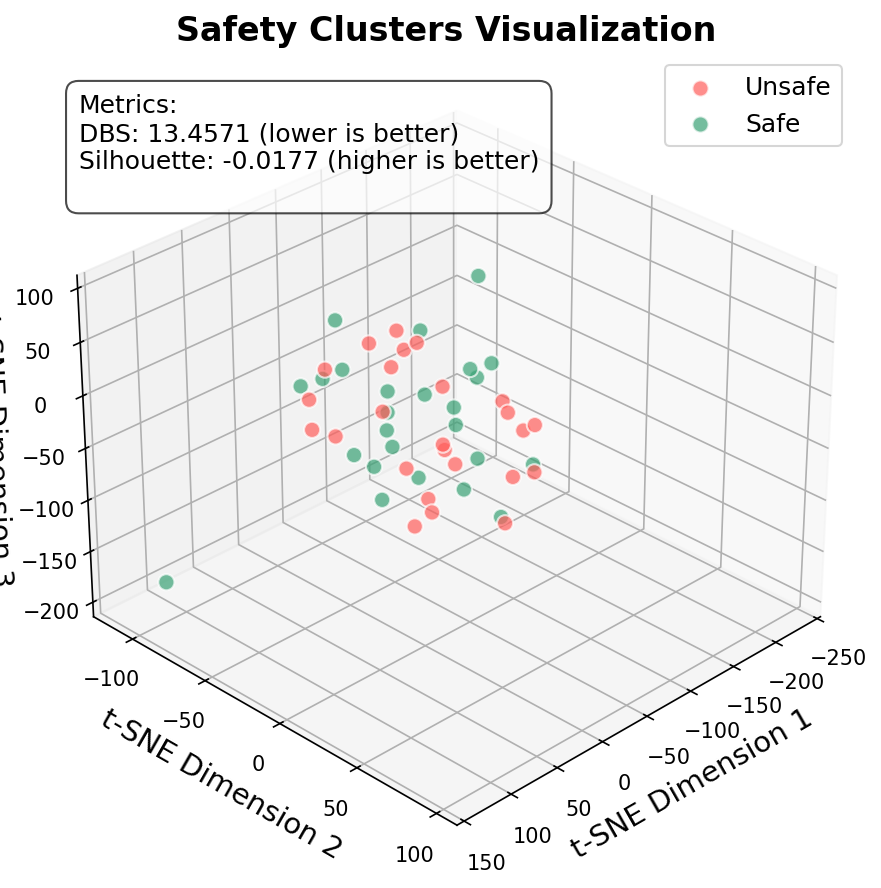


>>> Step 100: Triggering cluster visualization...
[Step 100] DBS: 11.9161, Silhouette: -0.0163 on 50 samples)


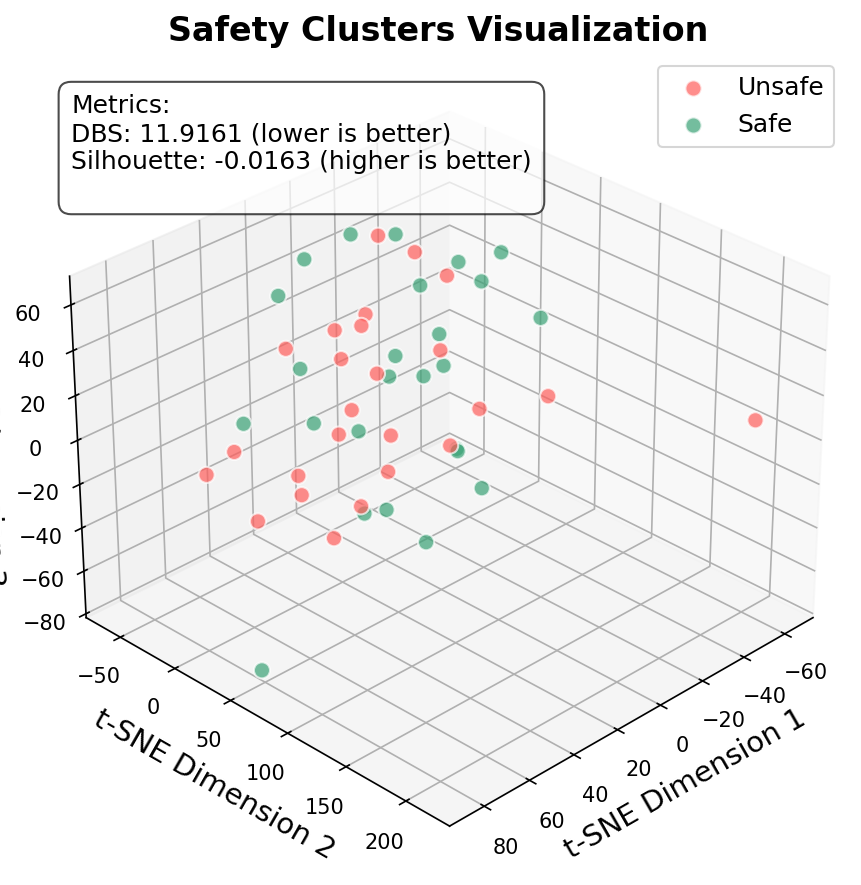

KeyboardInterrupt: 

: 

In [ ]:
# STEP 6: Train
trainer.train()